# Examining 2018 USGS Stream Gauge Data at Clear Creek in Golden, CO

### Misc notes

- API information is available at <https://waterservices.usgs.gov/rest/IV-Service.html#URLFormat>
- Data going back as far as October 1, 2007 are available for each site
- Timestamp returned by API is local (note the -6 at end, indicating that it is UTC-6). However, when converted using pd.to_datetime, it is changed to UTC. I fix this by putting data as index, and using localize>convert to set time zone to Mountain time.


### First import the libraries we'll use, and set some default plotting params.

In [1]:
# import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['lines.linewidth'] = 3

### Then construct the url for the API request

In [5]:
# parameters for API request
base_url = 'http://waterservices.usgs.gov/nwis/iv/?'
site = '06719505' # site number for Clear Creek in Golden
format_out = 'json'
indent = 'on' # indent json output for easier viewiing
#period = 'P50D' # last X days
variable = '00060' # discharge, cubic feet per second
startDT = '2018-1-1' 
endDT = '2018-06-15'

In [6]:
request_url = base_url + 'site=' + site + '&format=' + format_out + '&indent=' + indent + '&startDT=' + startDT + '&endDT=' + endDT + '&variable=' + variable
request_url = ('%ssite=%s&format=%s&indent=%s&startDT=%s&endDT=%s&variable=%s') % (base_url, site, format_out, indent, startDT, endDT, variable)

request_url

'http://waterservices.usgs.gov/nwis/iv/?site=06719505&format=json&indent=on&startDT=2018-1-1&endDT=2018-06-15&variable=00060'

## Next I want to convert to local (Mountain) timezone. The request actually returns data in local time, but  when read w/ pd_to_datetime it appears to conver back to UTC, so you have to reset it from UTC

In [7]:
# Make above into a general function
def get_flowdata(request_url):
    # get requested json
    resp = requests.get(request_url)
    #resp = requests.get(base_url, params=parameters)
    js = resp.json()
    value_dict = js['value']['timeSeries']
    val_dict2 = value_dict[0]['values']
    ivar= 0 # generalize for more than 1 variable?
    TS = val_dict2[ivar]['value'][0]['dateTime']
    pd.to_datetime(TS).tz_localize('UTC').tz_convert('US/Mountain')
    dict2 = val_dict2[ivar]['value']
    dates = []
    vals = []
    for row in dict2:
        dates.append(row['dateTime'])
        vals.append(row['value'])
    
    dates = pd.to_datetime(dates)
    # not sure how to set keys as variable name, hardwire for now 
    df = pd.DataFrame({'streamflow':vals},index=dates)
    df['streamflow']=df.streamflow.astype('float64')

    # make timezone in local (Mountain) time. The request actually returns data in local time, but 
    # when read w/ pd_to_datetime, you have to reset it from UTC
    df.index = df.index.tz_localize('UTC').tz_convert('US/Mountain')

    # add year and yday (yday for comparing different years etc.)
    df['yday'] = df.index.dayofyear
    df['year'] = df.index.year
    df['hour'] = df.index.hour

    df.head()
    
    return df

df = get_flowdata(request_url)
df.head()



,streamflow,yday,year,hour
2018-01-01 00:00:00-07:00,39.5,1,2018,0
2018-01-01 00:15:00-07:00,40.2,1,2018,0
2018-01-01 00:30:00-07:00,39.5,1,2018,0
2018-01-01 00:45:00-07:00,39.5,1,2018,0
2018-01-01 01:00:00-07:00,38.8,1,2018,1


## Look at year-to-date 2018 

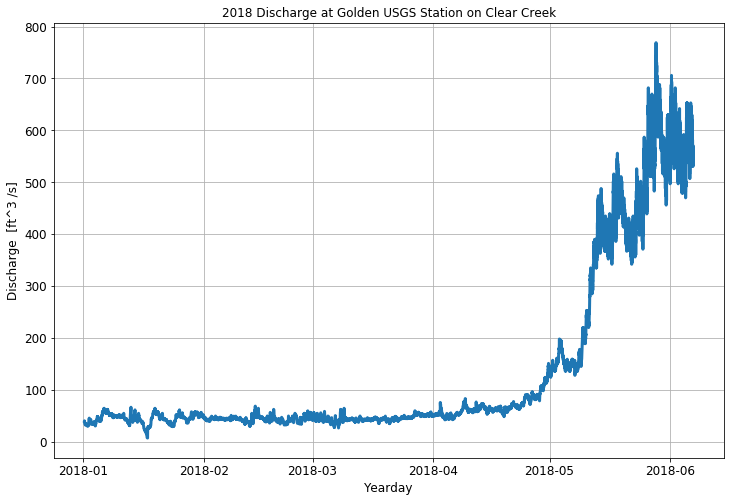

In [8]:
df2 = df.loc[df.year==2018]

plt.figure(figsize=(12,8))
plt.plot(df2.streamflow)
plt.grid()
#plt.xlim((100,300))
plt.xlabel('Yearday');
plt.title('2018 Discharge at Golden USGS Station on Clear Creek')
plt.ylabel('Discharge  [ft^3 /s]');
#plt.xlim(0,200)

plt.savefig('/Users/Andy/andypicke.github.io/images/clearcreek/2018_golden_StartOfRunoff.png')

## Zoom in on start of spring melt-off 

(736799.0, 736850.0)

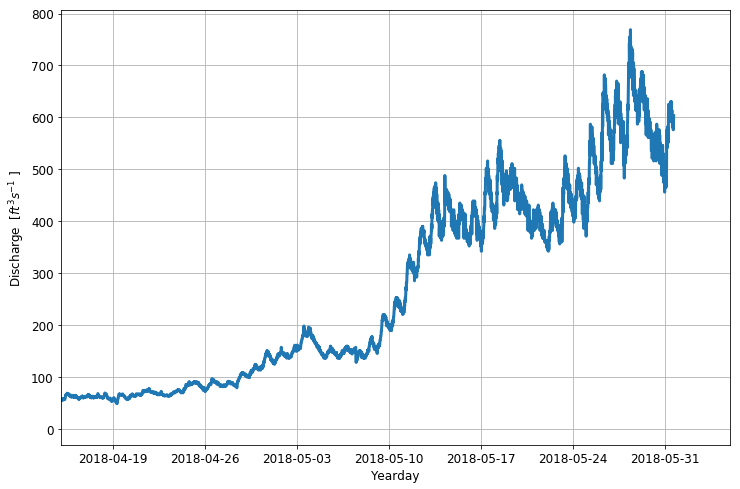

In [18]:
df2 = df.loc[df.year==2018]

plt.figure(figsize=(12,8))
plt.plot(df2.streamflow)
plt.grid()
#plt.xlim((100,300))
plt.xlabel('Yearday');
plt.ylabel(r'Discharge  [$ft^3s^{-1}$ ]')
plt.xlim('2018-4-15','2018-06-05')

#plt.savefig('/Users/Andy/andypicke.github.io/images/clearcreek/2017_peak_golden.png')

## Looks like there is some kind of daily cycle
- Looks like streamflow at Golden peaks around 7-9am?
- I would expect peak snowmelt to occur at miday/early afternoon?
- Does it take overnight for that signal to reach Golden?

(300, 700)

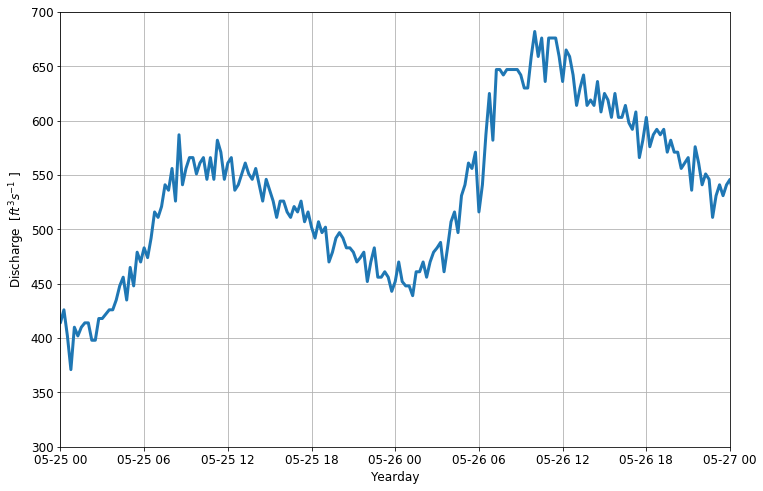

In [13]:
plt.figure(figsize=(12,8))
plt.plot(df2.streamflow)
plt.grid()
#plt.xlim((100,300))
plt.xlabel('Yearday');
plt.ylabel(r'Discharge  [$ft^3s^{-1}$ ]')
plt.xlim('2018-5-25','2018-05-27')
plt.ylim(300,700)

## Comparing Spring Melt-off for Different Years

Text(0,0.5,'Discharge  [$ft^3s^{-1}$ ]')

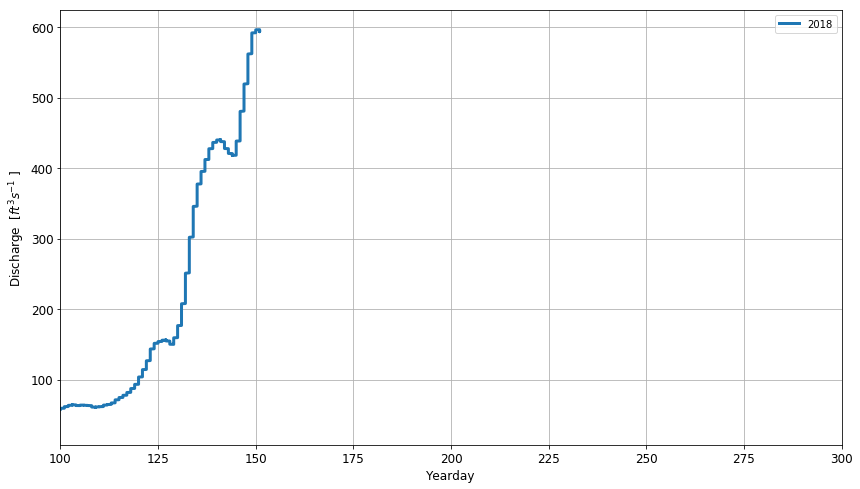

In [14]:

plt.figure(figsize=(14,8))
years = df.year.unique()
for year in years:
    df2 = df.loc[df.year==year]
    plt.plot(df2.yday,df2.streamflow.rolling(4*24*5).mean(),label=year)
    
plt.legend()
plt.grid()
plt.xlim((100,300))
plt.xlabel('Yearday');
plt.ylabel(r'Discharge  [$ft^3s^{-1}$ ]')

#plt.savefig('/Users/Andy/andypicke.github.io/images/clearcreek/allyears_peak_golden.png')